**Import Libraries**

In [1]:
#Installing the required packages
!pip install librosa
!pip install keras
!pip install tensorflow
!pip install ffmpeg

In [244]:
#Importing the required libraries
import os
import glob
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import fftpack
from scipy.stats import kurtosis,skew,mode
import sklearn.preprocessing,sklearn.decomposition
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold,train_test_split
from sklearn.feature_selection import f_classif
from keras import utils
import keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv1D, Conv2D, Flatten,Reshape, BatchNormalization, ZeroPadding2D,MaxPooling1D,AveragePooling1D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras import regularizers,optimizers
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.utils import to_categorical
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

**Extract Training Dataset**

In [3]:
#Function to extract the training data
def get_training(original_path):
    
    # Load the training data csv file into a dataframe. 
    df = pd.read_csv(os.path.join(original_path,'train.csv'))

    # Creating folder to store the Numpy arrays if they don't exist.
    if not os.path.exists(os.path.join(original_path,'train_extracted')):
        os.makedirs(os.path.join(original_path,'train_extracted'))

    # Getting the file names of audios from the dataframe.
    audio_files = np.array(df['new_id'])

    # Load each audio file, save it as a numpy array
    for i in range(len(audio_files)):    
        file_name = str(audio_files[i])
        d,r = librosa.load(os.path.join("Train",file_name + ".wav"),mono=True)
        if (np.isnan(d).any()):
            print(file_name)
        np.save(os.path.join(original_path, 'train_extracted',file_name+'.npy'),d)

**Extract Testing Dataset**

In [4]:
#Function to extract the testing data
def get_testing(original_path):

    # Load the test data csv file into a dataframe.
    df = pd.read_csv(os.path.join(original_path,'test_idx.csv'))

    # Creating folder to store the Numpy arrays if they don't exist.
    if not os.path.exists(os.path.join(original_path,'test_extracted')):
        os.makedirs(os.path.join(original_path,'test_extracted'))

    # Getting the file names of audios from the dataframe.
    audio_files = np.array(df['new_id'])

    # Load each audio file, save it as a numpy array
    for i in range(len(audio_files)):   
        file_name = str(audio_files[i])
        d,r = librosa.load(os.path.join("Test",file_name + ".wav"),mono=True)
        if (np.isnan(d).any()):
            print(file_name)
        np.save(os.path.join(original_path, 'test_extracted',file_name+'.npy'),d)

**Extract MFCC Features**

In [238]:
#Function to extract mfcc features which takes a csv file and the extracted folder as arguments
def get_mfcc_features(original_path, csv_file, extracted_folder,num_coeffs):

  # Load the csv file into a dataframe.
  df = pd.read_csv(os.path.join(original_path, csv_file ))

  # Get the audio file names.
  audio_extracted = np.array(df['new_id'])

  # Create an empty list to store the features.
  mfcc_features=list()

  # Looping on each Audio sequence array.
  for i in range(len(audio_extracted)):
        
    # Load the Audio sequence.
    audio_file_data = np.load(os.path.join(original_path, extracted_folder, str(audio_extracted[i])+'.npy'))

    audio_file_data = librosa.effects.preemphasis(y=audio_file_data, coef=0.90)
    # Calculate MFCC coefficients for the audio sequence.
    mfcc_data = librosa.feature.mfcc(y=audio_file_data,sr=8000, n_mfcc = num_coeffs)

    rms_data = librosa.feature.rms(y=audio_file_data, frame_length=128, hop_length=128)

    rms_db = librosa.power_to_db(rms_data**2, ref=np.max)
    # Calculating various statistic measures on the coefficients.

    # print(np.mean(mfcc_data, axis=1))
    # mfcc_data = mfcc_data - np.mean(mfcc_data, axis=1, keepdims=True)

    # spec = librosa.feature.spectral_centroid(y=audio_file_data, sr=8000)

    # spec_mean = np.mean(spec)

    # print(spec_mean)

    mean_mfcc = np.mean(mfcc_data, axis=1)

    # mean_mfcc = np.mean(np.abs(np.diff(mfcc_data, axis=1)), axis=1)
    # mean_mfcc= np.median(mfcc_data,axis=1)
    # mean_mfcc = np.std(mfcc_data, axis=1)

    addList = np.concatenate((np.array([np.mean(rms_db[0], axis=0)]), mean_mfcc))
    mfcc_features.append(addList) 

    D = np.abs(librosa.stft(audio_file_data))

    # Plot the spectrogram
    # plt.figure(figsize=(10, 6))
    # librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
    #                         y_axis='log', x_axis='time', sr=8000)
    # plt.title('Spectrogram')
    # plt.colorbar(format='%+2.0f dB')
    # plt.tight_layout()
    # plt.savefig('STFT_0.png')
    # plt.close

    # break

    # plt.figure(figsize=(10, 6))
    # librosa.display.specshow(mfcc_data, x_axis='time', sr=8000)
    # plt.title('MFCCs')
    # plt.colorbar()
    # plt.tight_layout()
    # plt.savefig('MFCC_0.png')
    # plt.close

    # break
    
  # Return feature list.
  return mfcc_features

**Random Forest Classifier**

In [6]:
#Function to use Random Forest classifier
def random_forest(X_train,Y_train,X_test, num_trees):

  # Intialize Random Forest classifier with number of trees as 800.
  random_forest = RandomForestClassifier(n_estimators= num_trees)

  # Fit Training Dataset.
  random_forest.fit(X_train, Y_train)

  # Predict and return labels.
  return random_forest.predict(X_test)

In [7]:
#Funtion to retrieve the labels of training data
def get_labels(original_path,csv_file):

  # Load the csv file into a dataframe.
  df = pd.read_csv(os.path.join(original_path, csv_file ))

  # Return the labels.
  labels = np.array(df['genre'])
  speakers = np.array(df['speaker'])

  return labels, speakers

In [8]:
#Funtion to standardize the features
def standardize_features(X_train,X_test):

  # Initialize standard scalar with zero mean
  sc = StandardScaler(with_mean=True)

  # Fit and transform the Training Dataset.
  X_train= sc.fit_transform(X_train)

  # Transform the testing set.
  X_test = sc.transform(X_test)
  
  return X_train,X_test

In [9]:
#Function to plot the confusion matrix
def plot_confusion_matrix(y_true,y_pred,label_names,classifier, num_ceoffs, num_trees):
    
    # Calculate the confusion matrix using the expected and predicted values.
    confusion_mat = confusion_matrix(np.array(y_true),y_pred,labels=label_names)
    
    #  Show the confusion matrix values.
    fig = plt.figure(figsize=(10,10))
    plt.imshow(confusion_mat, cmap=plt.cm.Blues, interpolation='nearest')
    
    # Set the x, y and title labels for the plot.
    plt.xlabel("Expected Outputs", fontsize=10)
    plt.ylabel("Actual Outputs", fontsize=10)
    plt.title("Confusion Matrix of "+ classifier + " classifier",fontsize=12)
    
    # Arrange the label names on the x and y axis.
    plt.xticks(np.arange(len(label_names)), label_names, rotation='vertical')
    plt.yticks(np.arange(len(label_names)), label_names)
    plt.tick_params(axis='both', labelsize='10')
    plt.tight_layout()
    for (y, x), label in np.ndenumerate(confusion_mat):
        if label != 0:
            plt.text(x,y,label,ha='center',va='center', size='12')
            
    # Show the plot
    plt.savefig('Images/confusion_matrix_coeffs' + str(num_ceoffs) + '_trees_' + str(num_trees) + '.png')
    plt.close()

In [ ]:
#Function to perform cross validation
def cross_validate(X_train,Y_train,data_rep, num_ceoffs, num_trees):

 # Choose classifiers based on the Data Representation.
 if data_rep=="mfcc":
    clf = random_forest
    classifier="Random Forest"
    sc= StandardScaler()
    X_train = sc.fit_transform(X_train)
 elif data_rep=="pca":
    clf = svm_classifier
    classifier="SVM"

 #Create the list with actual Label names.
 label_names=["Zero","One","Two","Three","Four","Five","Six","Seven","Eight","Nine"]

 # Create a Stratified KFold with 5 splits.
 k_fold = StratifiedKFold(n_splits=5,shuffle=True)

 # Create two empty lists to keep track of accuracies for plotting and predictions for confusion matrix.
 accuracies_clf = list()
 predictions_clf = list()
 actual_predictions = list()

 # Split the Dataset and Loop through each fold.
 for train_index, test_index in k_fold.split(X_train,Y_train):

    # Split the Dataset into Training and Validation.
    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]    

    # Fit and Predict the current fold using the classifier.
    pred = clf(x_train,y_train,x_test, num_trees)

    # Append the accuracies and predictions.
    predictions_clf.append(pred)
    actual_predictions.append(y_test)
    accuracies_clf.append(accuracy_score(pred,y_test))
 
 # Get the corresponding label names for the predictions.
 predictions_clf = np.array(predictions_clf).flatten()
 actual_predictions = np.array(actual_predictions).flatten()

 predictions_clf = [label_names[predictions_clf[i]] for i in range(len(predictions_clf))]
 actual_predictions = [label_names[actual_predictions[i]] for i in range(len(actual_predictions))]

 # Plot the confusion matrix for the classifier.
 plot_confusion_matrix(actual_predictions,predictions_clf,label_names,classifier,num_ceoffs,num_trees)

 # Plot the accuracy of the classifier for different folds
#  plt.plot([1,2,3,4,5],accuracies_clf)
#  plt.xticks(np.arange(1,5,1))
#  plt.xlabel("5-Fold CV")
#  plt.ylabel("Accuracy")
#  plt.show() 

 # Calculate and print the accuracy range with 99% confidence interval
 f =  f1_score(predictions_clf,actual_predictions, average='macro')
 accuracy_clf= accuracy_score(predictions_clf,actual_predictions)
 radius_clf = 2.58 * np.sqrt(accuracy_clf*(1-accuracy_clf)/len(predictions_clf))
 accuracy_clf_min =  (accuracy_clf - radius_clf)
 accuracy_clf_max =  (accuracy_clf + radius_clf)

 radius_clf = 2.58 * np.sqrt(f*(1-f)/len(predictions_clf))
 f_clf_min =  (f - radius_clf)
 f_clf_max =  (f + radius_clf)

 print('\n\n Accuracy of '+ classifier +' on Validation Dataset is ' + str(accuracy_clf))
 print('\n At 99% Confidence Interval :')
 print('\n The Accuracy of ' + classifier + ' is likely between ' + str(accuracy_clf_min) + ' and ' + str(accuracy_clf_max))

 print('\n\n Accuracy of '+ classifier +' on Validation Dataset is ' + str(f))
 print('\n At 99% Confidence Interval :')
 print('\n The Accuracy of ' + classifier + ' is likely between ' + str(f_clf_min) + ' and ' + str(f_clf_max))

 return(accuracy_clf, f)

**Extract Training and Testing Audio files into Numpy Arrays**

In [11]:
# Set the path of the project folder which has train, test folders and train.csv, test_idx.csv
original_path = os.path.realpath(".")

# Extract train and test dataset into numpy arrays and save them
get_training(original_path)
get_testing(original_path)

In [ ]:
# Loading the training and test set for ANOVA
num_coeffs = 12
X_train = get_mfcc_features(original_path,'train.csv','train_extracted', num_coeffs)
Y_train, speaker = get_labels(original_path,'train.csv')
X_test = get_mfcc_features(original_path,'test_idx.csv','test_extracted', num_coeffs)
X_train,X_test = standardize_features(X_train,X_test)


[   0.          213.11369888  426.22739775  639.34109663  852.45479551
 1069.957853   1332.9552128  1660.59774631 2068.77534111 2577.2836447
 3210.78410654 4000.        ]
(2400, 13)
[ 0.98279532  1.4945767  -0.50939931 -1.33543105 -1.11068131  0.41910856
  1.01588608  0.17687245  0.28750803  1.0823428   0.50699223 -1.60586848
 -1.80328056]
[ 3  4  8  6  9 10  2  7  5 11  0 12  1]


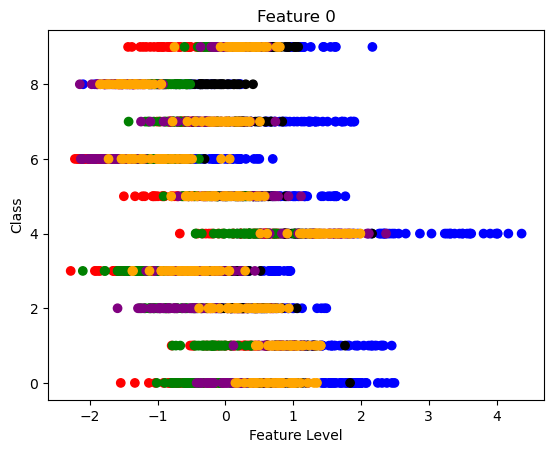

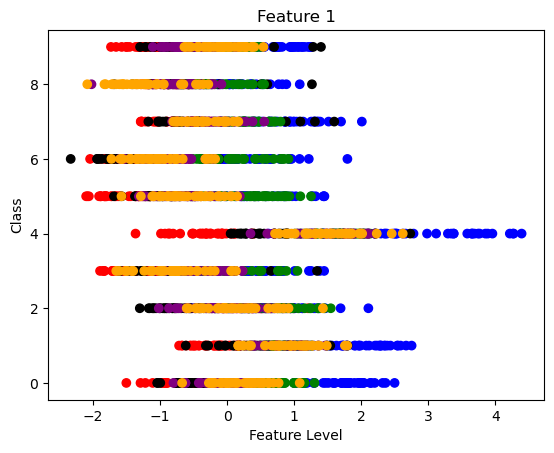

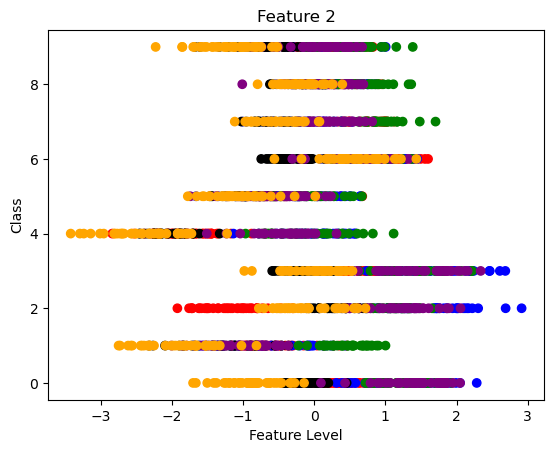

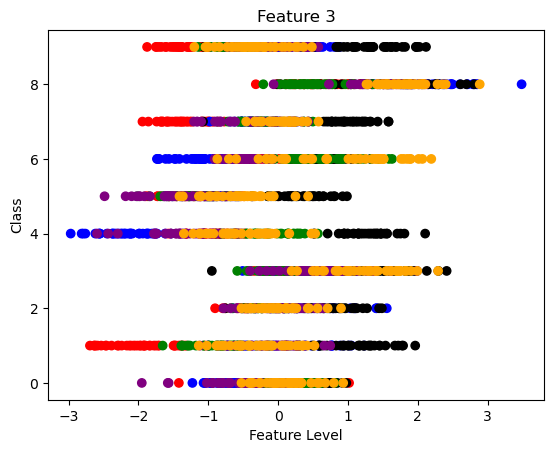

[254.16200412 181.89428193 179.48854661 156.91422822 115.37091588
  90.15457027  64.50999994  64.04070683  44.45740667  38.36763868
  29.67729169  21.56559017   3.76704881]
[1.76300095e-049 1.00221983e-004 2.34578900e-106 0.00000000e+000
 3.69666268e-263 2.69380149e-074 1.75621182e-233 1.25838872e-105
 2.25761709e-260 4.52729698e-180 8.53243801e-145 3.41931339e-064
 1.84719409e-035]


In [ ]:
# Classify and display the results of the 4 best features.
print(librosa.mel_frequencies(n_mels=num_coeffs, fmin=0, fmax=4000))

color_dict = {'george':'red', 'jackson':'blue', 'lucas':'black', 'nicolas':'green', 'theo':'purple', 'yweweler':'orange'}

print(np.array(X_train).shape)
print(X_train[0])
# X_train = np.array(X_train)
# print(len(X_train[:,1]))

# plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
# plt.show()
# plt.scatter(X_train[:,2], X_train[:,3], c=Y_train)
# plt.show()

f, p = f_classif(X_train, Y_train)

most_var = np.flip(np.argsort(f))
print(most_var)

for k in list(range(0,4)):
    plt.scatter(X_train[:,most_var[k]], Y_train, color=[color_dict[i] for i in speaker ])
    plt.ylabel("Class")
    plt.xlabel("Feature Level")
    plt.title('Feature ' + str(k))
    plt.show()

print(f[most_var])
print(p)

**Random Forest on MFCC**

In [ ]:
# Conduct search on the number of MFCC coeffs
accuracy = []
f1_total = []
trees = 20
    
for i in range(8,17):
    # Extract MFCC features and standardize them.
    X_train = get_mfcc_features(original_path,'train.csv','train_extracted', i)

    Y_train, _ = get_labels(original_path,'train.csv')
    X_test = get_mfcc_features(original_path,'test_idx.csv','test_extracted', i)
    X_train,X_test = standardize_features(X_train,X_test)

    print(np.array(X_train).shape)
    print(np.array(Y_train).shape)

    # Cross Validate MFCC Features.

    acc, f1 = (cross_validate(np.array(X_train),np.array(Y_train).flatten(),"mfcc", i, trees))
    accuracy.append(acc)
    f1_total.append(f1)

    # Classify MFCC Test Features using Random Forest Classifier.
    y_test_rf = random_forest(X_train,Y_train,X_test, trees)
    Y_test = pd.read_csv(os.path.join(original_path,'test_idx.csv'))
    Y_test['genre'] = y_test_rf.tolist()
    Y_test = Y_test.rename(columns={"new_id":"id"})
    Y_test.to_csv(os.path.join(original_path,'predict_rf.csv'),index=False)


(2400, 9)
(2400,)


 Accuracy of Random Forest on Validation Dataset is 0.8091666666666667

 At 99% Confidence Interval :

 The Accuracy of Random Forest is likely between 0.788471916149728 and 0.8298614171836054
(2400, 10)
(2400,)


 Accuracy of Random Forest on Validation Dataset is 0.825

 At 99% Confidence Interval :

 The Accuracy of Random Forest is likely between 0.8049894012458397 and 0.8450105987541602
(2400, 11)
(2400,)


 Accuracy of Random Forest on Validation Dataset is 0.8320833333333333

 At 99% Confidence Interval :

 The Accuracy of Random Forest is likely between 0.8123979263083418 and 0.8517687403583247
(2400, 12)
(2400,)


 Accuracy of Random Forest on Validation Dataset is 0.8575

 At 99% Confidence Interval :

 The Accuracy of Random Forest is likely between 0.8390906446167988 and 0.8759093553832012
(2400, 13)
(2400,)


 Accuracy of Random Forest on Validation Dataset is 0.8675

 At 99% Confidence Interval :

 The Accuracy of Random Forest is likely between 0.8496

9
9


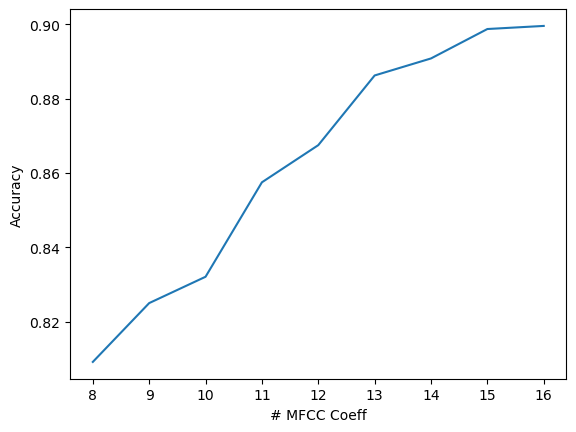

9
9


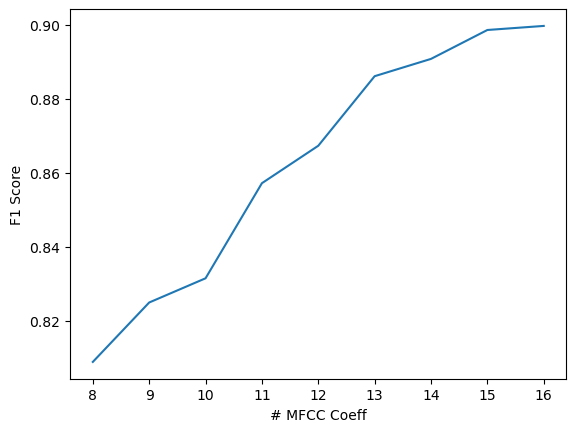

[0.8091666666666667, 0.825, 0.8320833333333333, 0.8575, 0.8675, 0.88625, 0.8908333333333334, 0.89875, 0.8995833333333333]
[0.8089410587673285, 0.8249888114760073, 0.8315261103086747, 0.8572060283823756, 0.8673192194147257, 0.8861038624149724, 0.8907779767114082, 0.8985834756486446, 0.8996810922342027]
0.8861038624149724
0.8693732862174165
0.9028344386125283


In [ ]:
# Plot F1 score and accuracy
print(len(range(8,17)))
print(len(accuracy))

plt.plot(range(8,17),accuracy)
plt.ylabel("Accuracy")
plt.xlabel("# MFCC Coeff")
plt.savefig('Images\Accuracy.png')
plt.show()

print(len(range(8,17)))
print(len(accuracy))

plt.plot(range(8,17),f1_total)
plt.ylabel("F1 Score")
plt.xlabel("# MFCC Coeff")
plt.savefig('Images\F1Total.png')
plt.show()